# Assignment 2021-2022, Question 1

### 1.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'google'

### 2.

In [3]:
def get_ff30_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    ind = pd.read_csv("/content/drive/MyDrive/data/ind30_m_vw_rets.csv", header=0, index_col=0)/100 
    #ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    #ind.columns = ind.columns.str.strip()
    return ind

### 3. 4. Complete the defintion of the risk contribution function

In [4]:
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

def risk_contribution(w,cov):
    """
Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # QUESTION 3. Marginal contribution of each constituent
    marginal_contrib = w.T @ cov
    # QUESTION 4. Risk contribution of the portfolio
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

### 5.

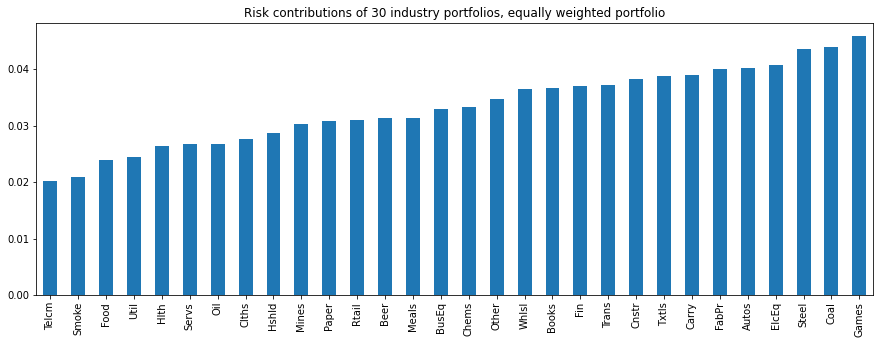

In [5]:
# We included the get_rf() function early on in order to be able to implement an rf input in the weight_ew() function.
# This will come in handy later on when we will backtest an equal weighted portfolio.

def get_rf():
    """
    import the time series of the risk-free rate
    """
    rf = pd.read_excel("/content/drive/MyDrive/data/rf.xlsx", header=0, index_col=0)
    rf.index = pd.to_datetime(rf.index, format="%Y%m").to_period('M')
    rf.columns = rf.columns.str.strip()
    return rf

def weight_ew(r, rf):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)
    
ff30 = get_ff30_returns()
rf_data = get_rf()
w = weight_ew(ff30, rf_data)
covff30 = ff30.cov()
riskcont = risk_contribution(w,covff30)
riskcont.sort_values().plot.bar(figsize = (15,5), title = "Risk contributions of 30 industry portfolios, equally weighted portfolio")

### 6.

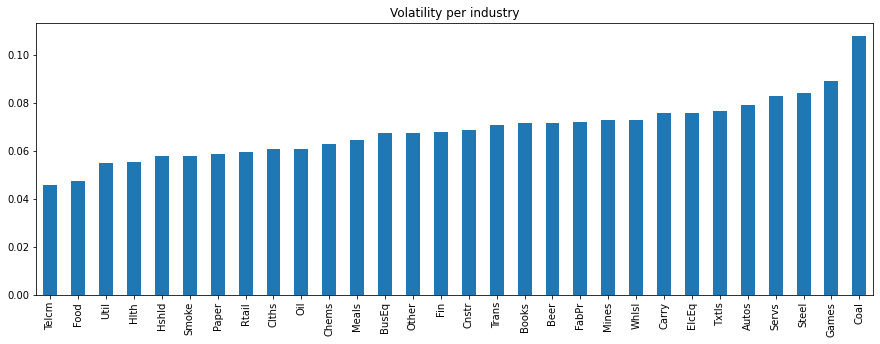

In [6]:
sigmaind = ff30.std()
sigmaind.sort_values().plot.bar(figsize = (15,5), title = "Volatility per industry")
sigmaind.corr(riskcont)

### 7.

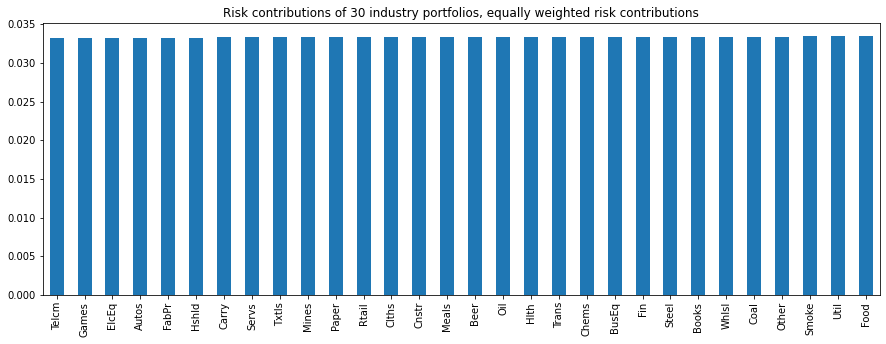

In [7]:
from scipy.optimize import minimize

# Functions where slightly altered throughout the assignment in order to incorporate differently named variables.

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=covff30)

equal_risk_contributions_weights = equal_risk_contributions(covff30)
equal_risk_contributions_weights_df = pd.Series(equal_risk_contributions_weights, index = ff30.columns)
risk_contribution(equal_risk_contributions_weights, covff30).sort_values().plot.bar(figsize = (15,5), title = "Risk contributions of 30 industry portfolios, equally weighted risk contributions")

### 8.

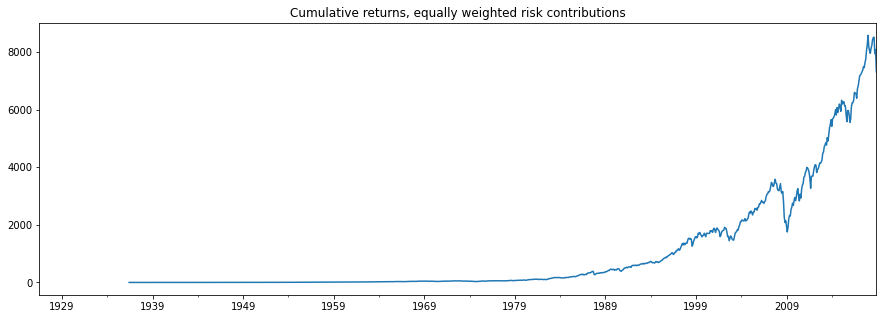

In [8]:
def weight_erc(r,rf):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    cov=r.cov()
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=covff30)

def backtest_ws(r, rf,estimation_window=60, weighting= weight_ew):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [weighting(r.iloc[win[0]:win[1]], rf.iloc[win[0]:win[1]]) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) # mincount is to generate NAs if all inputs are NAs
    return returns

backtest_equal_risk_contributions = backtest_ws(ff30, get_rf(), estimation_window=120, weighting= weight_erc)
(1 + backtest_equal_risk_contributions).cumprod().plot(figsize=(15,5), title="Cumulative returns, equally weighted risk contributions")

### 9.

In [9]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def weight_msr (r, rf):
    """
    Returns the weights of the portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    er=r.mean()
    cov=r.cov()
    rff= rf.rf.values.mean()
    return pd.Series(msr(rff, er, cov), index=r.columns)

def weight_gmv(r, rf):
    """
    Returns the weights of the portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    cov=r.cov()
    
    def gmv(r,rf):
        """
        Returns the weights of the Global Minimum Volatility portfolio
        given a covariance matrix
        """
        n = cov.shape[0]
        return msr(0, np.repeat(1, n), cov)

    return pd.Series(gmv(cov,rf), index=r.columns)

def weight_erc(r,rf):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    cov=r.cov()
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=covff30)

def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x



In [10]:
backtest_ew = backtest_ws(ff30, get_rf(), estimation_window=120, weighting= weight_ew)

In [11]:
backtest_gmv = backtest_ws(ff30, get_rf(), estimation_window=120, weighting= weight_gmv)

In [12]:
backtest_msr = backtest_ws(ff30, get_rf(), estimation_window=120, weighting= weight_msr)

### 10.

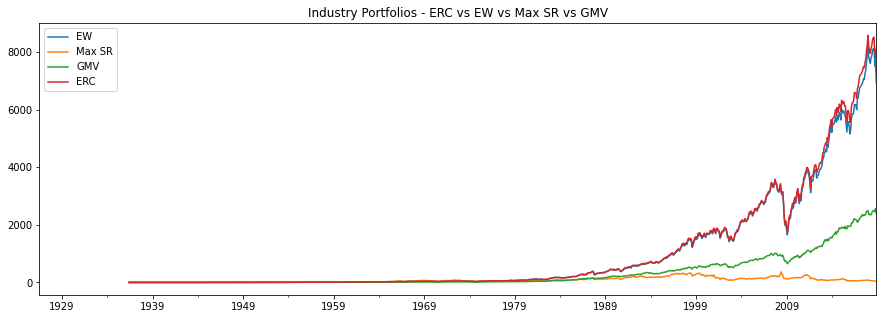

In [13]:
backtest_4 = pd.DataFrame({"EW": backtest_ew, "Max SR": backtest_msr, "GMV": backtest_gmv, "ERC": backtest_equal_risk_contributions})
(1+backtest_4).cumprod().plot(figsize=(15,5), title="Industry Portfolios - ERC vs EW vs Max SR vs GMV")

# Assignment 2021-2022, Question 2

### 1.

In [14]:
brka_d = pd.read_csv("/content/drive/MyDrive/labs/AM Lab 3/brka_d_ret.csv", parse_dates=True, index_col=0)

def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

brka_m = brka_d.resample('M').apply(compound).to_period('M')

### 2.

In [15]:
def get_fff_returns():
    """
    Load the Fama-French Research Factor Monthly Dataset
    """
    rets = pd.read_csv("/content/drive/MyDrive/data/F-F_Research_Data_Factors_m.csv",
                       header=0, index_col=0, na_values=-99.99)/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets

fff30 = get_fff_returns()

### 3.

In [27]:
from re import A
import statsmodels.api as sm
brka_excess = brka_m["1990":"2003"] - fff30.loc["1990":"2003", ['RF']].values
mkt_excess = fff30.loc["1990":"2003",['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
lm = sm.OLS(brka_excess, exp_var).fit()

b = pd.DataFrame(brka_excess, columns=["Benchmark Excess Return"])
beta = lm.params["Mkt-RF"]
b["Benchmark Excess Return"] = mkt_excess * beta
alpha = lm.params["Constant"]
b["a"] = alpha
b["Sum Nominator Tracking Error"] = (brka_excess["BRKA"]- b["Benchmark Excess Return"]-alpha)**2

tracking_error_squared = b["Sum Nominator Tracking Error"].mean()
tracking_error = np.sqrt(tracking_error_squared)

information_ratio = alpha/tracking_error

print("CAPM conclusions:")
print(f"For the sample 1990-2003, the alpha is equal to: {alpha}.")
print(f"The tracking error is equal to: {tracking_error}.")
print(f"The information ratio is equal to: {information_ratio}.")
print(f"Beta is equal to: {beta}.")

lm.summary()

CAPM conclusions:
For the sample 1990-2003, the alpha is equal to: 0.008715172813132246.
The tracking error is equal to: 0.06284422779019143.
The information ratio is equal to: 0.13867897052102035.
Beta is equal to: 0.587740336281837.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     28.90
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           2.55e-07
Time:                        13:00:27   Log-Likelihood:                 226.49
No. Observations:                 168   AIC:                            -449.0
Df Residuals:                     166   BIC:                            -442.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5877      0.109      5.376      0.000       0.372       0.804
Constant       0.0087      0.005      1.771      0.078      -0.001       0.018
==============================================================================
Omnibus:                       19.104   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.322
Skew:                           0.571   Prob(JB):                     5.81e-08
Kurtosis:                       4.859   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This implies that the CAPM benchmark for the sample 1990-2003 consists of 42 cents in T-Bills and 58 cents in the market. i.-e. each dollar in the Berkshire Hathaway portfolio is equivalent to 42 cents in T-Bills and 58 cents in the market. Relative to this, the Berkshire Hathaway is adding (i.e. has $\alpha$ of) 0.87% _(per month!)_ although the degree of statistica significance is not very high (above 5%).

In [28]:
brka_excess = brka_m["2003":"2018"] - fff30.loc["2003":"2018", ['RF']].values
mkt_excess = fff30.loc["2003":"2018",['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
lm = sm.OLS(brka_excess, exp_var).fit()


b = pd.DataFrame(brka_excess, columns=["Benchmark Excess Return"])
beta = lm.params["Mkt-RF"]
b["Benchmark Excess Return"] = mkt_excess * beta
alpha = lm.params["Constant"]
b["a"] = alpha
b["Sum Nominator Tracking Error"] = (brka_excess["BRKA"]- b["Benchmark Excess Return"]-alpha)**2

tracking_error_squared = b["Sum Nominator Tracking Error"].mean()
tracking_error = np.sqrt(tracking_error_squared)

information_ratio = alpha/tracking_error

print("CAPM conclusions:")
print(f"For the sample 2003-2018, the alpha is equal to: {alpha}.")
print(f"The tracking error is equal to: {tracking_error}.")
print(f"The information ratio is equal to: {information_ratio}.")
print(f"Beta is equal to: {beta}.")

lm.summary()

CAPM conclusions:
For the sample 2003-2018, the alpha is equal to: 0.0032248821766425943.
The tracking error is equal to: 0.039045529978448186.
The information ratio is equal to: 0.08259286475103861.
Beta is equal to: 0.5872689234928121.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     68.12
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           2.54e-14
Time:                        13:00:33   Log-Likelihood:                 350.22
No. Observations:                 192   AIC:                            -696.4
Df Residuals:                     190   BIC:                            -689.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5873      0.071      8.253      0.000       0.447       0.728
Constant       0.0032      0.003      1.120      0.264      -0.002       0.009
==============================================================================
Omnibus:                       59.255   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.730
Skew:                           1.274   Prob(JB):                     3.11e-38
Kurtosis:                       6.886   Cond. No.                         25.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This implies that the CAPM benchmark for the sample 2003-2018 consists of 42 cents in T-Bills and 58 cents in the market. i.-e. each dollar in the Berkshire Hathaway portfolio is equivalent to 42 cents in T-Bills and 58 cents in the market. Relative to this, the Berkshire Hathaway is adding (i.e. has $\alpha$ of) 0.32% _(per month!)_ , the alpha value is however insignificant.

In [29]:
brka_excess = brka_m["1990":"2018"] - fff30.loc["1990":"2018", ['RF']].values
mkt_excess = fff30.loc["1990":"2018",['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
lm = sm.OLS(brka_excess, exp_var).fit()

b = pd.DataFrame(brka_excess, columns=["Benchmark Excess Return"])
beta = lm.params["Mkt-RF"]
b["Benchmark Excess Return"] = mkt_excess * beta
alpha = lm.params["Constant"]
b["alpha"] = alpha
b["Sum Nominator Tracking Error"] = (brka_excess["BRKA"]- b["Benchmark Excess Return"]-alpha)**2

tracking_error_squared = b["Sum Nominator Tracking Error"].mean()
tracking_error = np.sqrt(tracking_error_squared)

information_ratio = alpha/tracking_error

print("CAPM conclusions:")
print(f"For the sample 1990-2018, the alpha is equal to: {alpha}.")
print(f"The tracking error is equal to: {tracking_error}.")
print(f"The information ratio is equal to: {information_ratio}.")
print(f"Beta is equal to: {beta}.")

lm.summary()

CAPM conclusions:
For the sample 1990-2018, the alpha is equal to: 0.006069425790323521.
The tracking error is equal to: 0.05194617818753483.
The information ratio is equal to: 0.11684066089350842.
Beta is equal to: 0.5779457613060566.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     76.69
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           9.03e-17
Time:                        13:03:10   Log-Likelihood:                 535.44
No. Observations:                 348   AIC:                            -1067.
Df Residuals:                     346   BIC:                            -1059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5779      0.066      8.757      0.000       0.448       0.708
Constant       0.0061      0.003      2.150      0.032       0.001       0.012
==============================================================================
Omnibus:                       66.402   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.134
Skew:                           0.858   Prob(JB):                     1.56e-43
Kurtosis:                       6.263   Cond. No.                         23.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This implies that the CAPM benchmark for the sample 1990-2018 consists of 43 cents in T-Bills and 57 cents in the market. i.-e. each dollar in the Berkshire Hathaway portfolio is equivalent to 43 cents in T-Bills and 57 cents in the market. Relative to this, the Berkshire Hathaway is adding (i.e. has  α  of) 0.61% (per month!) , the alpha value is significant at 95% level.

### 4.

In [30]:
brka_excess = brka_m["1990":"2003"]- fff30.loc["1990":"2003", ['RF']].values
mkt_excess = fff30.loc["1990":"2003",['Mkt-RF']]
    
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
exp_var["Value"] = fff30.loc["1990":"2003",['HML']]
exp_var["Size"] = fff30.loc["1990":"2003",['SMB']]
lm = sm.OLS(brka_excess, exp_var).fit()
      
alpha = lm.params["Constant"]
beta = lm.params["Mkt-RF"]
beta_size = lm.params["Size"]
beta_value = lm.params["Value"]      
b = pd.DataFrame(brka_excess, columns=["Benchmark Excess Return"])
b["Benchmark Excess Return"] = mkt_excess * beta 
b["Benchmark Excess Size"] = exp_var["Size"] * beta_size
b["Benchmark Excess Value"] = exp_var["Value"] * beta_value      
b["alpha"] = alpha
b["Sum Nominator Tracking Error"] = (brka_excess["BRKA"] - b["Benchmark Excess Return"] - b["Benchmark Excess Size"] - b["Benchmark Excess Value"] - alpha) **2

tracking_error_squared = b["Sum Nominator Tracking Error"].mean()
tracking_error = np.sqrt(tracking_error_squared)

information_ratio = alpha/tracking_error

print("FF3M conclusions:")
print(f"For the sample 1990-2003, the alpha is equal to: {alpha}.")
print(f"The tracking error is equal to: {tracking_error}.")
print(f"The information ratio is equal to: {information_ratio}.")
print(f"Beta is equal to: {beta}.")

lm.summary()

FF3M conclusions:
For the sample 1990-2003, the alpha is equal to: 0.005988109092099483.
The tracking error is equal to: 0.05565840533108453.
The information ratio is equal to: 0.10758678867062686.
Beta is equal to: 0.8402058632267428.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     27.16
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           2.59e-14
Time:                        13:10:39   Log-Likelihood:                 246.89
No. Observations:                 168   AIC:                            -485.8
Df Residuals:                     164   BIC:                            -473.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.8402      0.110      7.618      0.000       0.622       1.058
Constant       0.0060      0.005      1.330      0.185      -0.003       0.015
Value          0.5334      0.160      3.331      0.001       0.217       0.850
Size          -0.4775      0.124     -3.851      0.000      -0.722      -0.233
==============================================================================
Omnibus:                       13.991   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.618
Skew:                           0.619   Prob(JB):                     0.000406
Kurtosis:                       3.835   Cond. No.                         41.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For the period 1990-2003: 
The alpha has fallen from .87% to about .60% per month. The loading on the market has moved up from 0.58 to 0.84, which means that adding these new explanatory factors did change things. If we had added irrelevant variables, the loading on the market would be unaffected.

We can interpret the loadings on Value being positive as saying that Hathaway has a significant Value tilt. Additionally, the negative tilt on size suggests that Hathaway tends to invest in large companies.

Each dollar invested in Hathaway is: 84 cents in the market, 16 cents in Bills, 53 cents in Value stocks and short 47 cents in Growth stocks. 

In [31]:
brka_excess = brka_m["2003":"2018"]- fff30.loc["2003":"2018", ['RF']].values
mkt_excess = fff30.loc["2003":"2018",['Mkt-RF']]
    
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
exp_var["Value"] = fff30.loc["2003":"2018",['HML']]
exp_var["Size"] = fff30.loc["2003":"2018",['SMB']]
lm = sm.OLS(brka_excess, exp_var).fit()
      
alpha = lm.params["Constant"]
beta = lm.params["Mkt-RF"]
beta_size = lm.params["Size"]
beta_value = lm.params["Value"]      
b = pd.DataFrame(brka_excess, columns=["Benchmark Excess Return"])
b["Benchmark Excess Return"] = mkt_excess * beta 
b["Benchmark Excess Size"] = exp_var["Size"] * beta_size
b["Benchmark Excess Value"] = exp_var["Value"] * beta_value      
b["alpha"] = alpha
b["Sum Nominator Tracking Error"] = (brka_excess["BRKA"] - b["Benchmark Excess Return"] - b["Benchmark Excess Size"] - b["Benchmark Excess Value"] - alpha) **2

tracking_error_squared = b["Sum Nominator Tracking Error"].mean()
tracking_error = np.sqrt(tracking_error_squared)

information_ratio = alpha/tracking_error

print("FF3M conclusions:")
print(f"For the sample 2003-2018, the alpha is equal to: {alpha}.")
print(f"The tracking error is equal to: {tracking_error}.")
print(f"The information ratio is equal to: {information_ratio}.")
print(f"Beta is equal to: {beta}.")

lm.summary()

FF3M conclusions:
For the sample 2003-2018, the alpha is equal to: 0.003684743263226411
The tracking error is equal to: 0.0375191190756964
The information ratio is equal to: 0.0982097488960838
Beta is equal to: 0.6027135998915978.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     29.53
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           1.08e-15
Time:                        13:21:03   Log-Likelihood:                 357.88
No. Observations:                 192   AIC:                            -707.8
Df Residuals:                     188   BIC:                            -694.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6027      0.076      7.927      0.000       0.453       0.753
Constant       0.0037      0.003      1.323      0.188      -0.002       0.009
Value          0.3577      0.116      3.080      0.002       0.129       0.587
Size          -0.3218      0.127     -2.526      0.012      -0.573      -0.071
==============================================================================
Omnibus:                       66.066   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.594
Skew:                           1.384   Prob(JB):                     2.52e-47
Kurtosis:                       7.377   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For the period 2003-2018: 
The alpha has increased from .32% to about .37% per month (alpha significance is still very weak). The loading on the market has moved up from 0.58 to 0.60, which means that adding these new explanatory factors did change things. If we had added irrelevant variables, the loading on the market would be unaffected.

We can interpret the loadings on Value being positive as saying that Hathaway has a significant Value tilt. Additionally, the negative tilt on size suggests that Hathaway tends to invest in large companies.

Each dollar invested in Hathaway is: 60 cents in the market, 40 cents in Bills, 35 cents in Value stocks and short 32 cents in Growth stocks. 

In [32]:
brka_excess = brka_m["1990":"2018"]- fff30.loc["1990":"2018", ['RF']].values
mkt_excess = fff30.loc["1990":"2018",['Mkt-RF']]
    
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
exp_var["Value"] = fff30.loc["1990":"2018",['HML']]
exp_var["Size"] = fff30.loc["1990":"2018",['SMB']]
lm = sm.OLS(brka_excess, exp_var).fit()
      
alpha = lm.params["Constant"]
beta = lm.params["Mkt-RF"]
beta_size = lm.params["Size"]
beta_value = lm.params["Value"]      
b = pd.DataFrame(brka_excess, columns=["Benchmark Excess Return"])
b["Benchmark Excess Return"] = mkt_excess * beta 
b["Benchmark Excess Size"] = exp_var["Size"] * beta_size
b["Benchmark Excess Value"] = exp_var["Value"] * beta_value      
b["alpha"] = alpha
b["Sum Nominator Tracking Error"] = (brka_excess["BRKA"] - b["Benchmark Excess Return"] - b["Benchmark Excess Size"] - b["Benchmark Excess Value"] - alpha) **2

tracking_error_squared = b["Sum Nominator Tracking Error"].mean()
tracking_error = np.sqrt(tracking_error_squared)

information_ratio = alpha/tracking_error

print("FF3M conclusions:")
print(f"For the sample 1990-2018, the alpha is equal to: {alpha}.")
print(f"The tracking error is equal to: {tracking_error}.")
print(f"The information ratio is equal to: {information_ratio}.")
print(f"Beta is equal to: {beta}.")

lm.summary()

FF3M conclusions:
For the sample 1990-2018, the alpha is equal to: 0.005165397179299436.
The tracking error is equal to: 0.04743990013891699.
The information ratio is equal to: 0.10888296906557016.
Beta is equal to: 0.7096050666739291.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     53.29
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           2.59e-28
Time:                        13:23:12   Log-Likelihood:                 567.01
No. Observations:                 348   AIC:                            -1126.
Df Residuals:                     344   BIC:                            -1111.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.7096      0.063     11.350      0.000       0.587       0.833
Constant       0.0052      0.003      1.991      0.047    6.18e-05       0.010
Value          0.4053      0.090      4.494      0.000       0.228       0.583
Size          -0.4829      0.085     -5.696      0.000      -0.650      -0.316
==============================================================================
Omnibus:                       64.922   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.061
Skew:                           0.962   Prob(JB):                     1.05e-30
Kurtosis:                       5.413   Cond. No.                         38.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For the period 1990-2018: The alpha has decreased from .61% to about .52% per month (alpha significance is still very weak). The loading on the market has moved up from 0.57 to 0.70, which means that adding these new explanatory factors did change things. If we had added irrelevant variables, the loading on the market would be unaffected.

We can interpret the loadings on Value being positive as saying that Hathaway has a significant Value tilt. Additionally, the negative tilt on size suggests that Hathaway tends to invest in large companies.

Each dollar invested in Hathaway is: 70 cents in the market, 30 cents in Bills, 40 cents in Value stocks and short 48 cents in Growth stocks.